### Линейные методы в машинном обучении

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Линейная регрессия

Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть:
$$ y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b $$,
где у - целевая переменная (что мы хотим предсказать), $x_i$ -- признак объекта х, $w_i$ -- вес i-го признака, b -- bias (смещение, свободный член)

Часто предполагают, что объект х содержит в себе фиктивный признак, который всегда равен 1, тогда bias это есть вес этого признака. В этом случае формула принимает простой вид:
$$ y = <w, x> $$,
где $<\cdot, \cdot>$ -- скалярное произведение векторов.

В матричной форме, в случае, когда у нас есть n объектов формулу можно переписать следующим образом:
$$ Y = Xw $$,
Y -- вектор размера n, X -- матрица объекты-признаки размера $n \times k$, w -- вектор весов размера k.

Решение по методу наименьших квадратов дает 
$$ w = (X^TX)^{-1}X^TY $$

#### Задание 1

Реализуйте линейную регрессию, которая вычисляет веса признаков по формуле указанной выше

In [0]:
class MyLinearRegression:
    
    def __init__(self):
        self.w = None
        pass
    
    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!
        X = np.concatenate([X, np.ones([len(X), 1])], 1)
        # В эту переменную нужно сохранить результат:
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        X = np.concatenate([X, np.ones([len(X), 1])], 1)
        # ВАШ КОД ЗДЕСЬ:
        y_pred = ... # Результат предсказания
        return y_pred
    
    def get_weights(self):
        return w

Протестируем нашу модель на искуственных данных

In [0]:
X = np.linspace(10, 20, 100)
y = -3 * X + 100

X_train = X[:50].reshape(-1, 1)
y_train = y[:50] + np.random.randn(50) * 10

X_test = X[50:].reshape(-1, 1)
y_test = y[50:] + np.random.randn(50) * 10

In [0]:
print(X_train.shape)
print(y_train.shape)

(50, 1)
(50,)


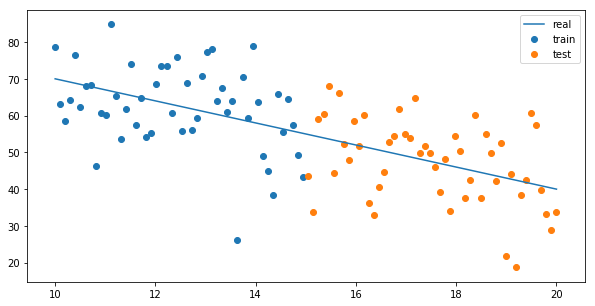

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(X, y, label='real')
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

#### Задание 2

Обучите вашу модель на тренировочной выборке и предскажите значения на тесте.
Предсказанные ответы сохраните в переменную $\textbf{predictions}$, а веса модели сохраните в переменную $\textbf{w}$

In [0]:
regressor = MyLinearRegression()

# Ваш код здесь

[-2.20746085 87.31414442]


Визуализируем предсказания

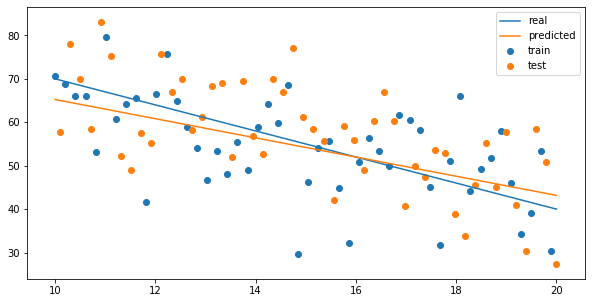

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(X, y, label='real')
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X.reshape(-1, 1)), label='predicted')
plt.legend()
plt.show()

#### Задание 3

Вычислите среднеквадратичную ошибку на трейне и на тесте.
Какие результаты вы ожидаете получить? Какие получились? Почему?

In [0]:
from sklearn.metrics import mean_squared_error

# ВАШ КОД ЗДЕСЬ

print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

Train RMSE:  9.505397201301475
Test RMSE:  9.891916618975706


### Ridge&Lasso

На практике точные формулы для подсчета коэффициентов линейной регрессии не используются, а используется метод градиентного спуска который состоит в подсчете производных от ошибки и шагу в направлении наискорейшего убывания функции (напомню, что мы стремимся минимизировать функцию потерь). Эти методы работают быстрее, чем точное вычисление обратных матриц и их перемножение.
Более того, во многих задачах это единственный способ обучить модель, так как не всегда (на самом деле почти никогда) удается выписать точную формулу для минимума сложного функционала ошибки.

Давайте рассмотрим реализации линейных регрессоров в библиотеке sklearn

In [0]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [0]:
import sklearn
sklearn.__version__

# conda install sklearn=0.20.3

'0.20.3'

Будем работать с датасетом wine

In [0]:
from sklearn.datasets import load_wine

In [0]:
wine_data = load_wine()

In [0]:
X = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])
y = wine_data['target']

In [0]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [0]:
y[:10000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

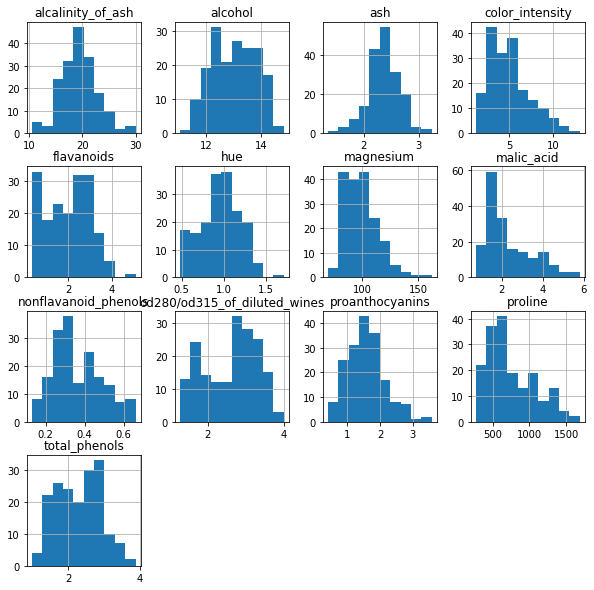

In [0]:
_ = X.hist(X.columns, figsize=(10, 10))

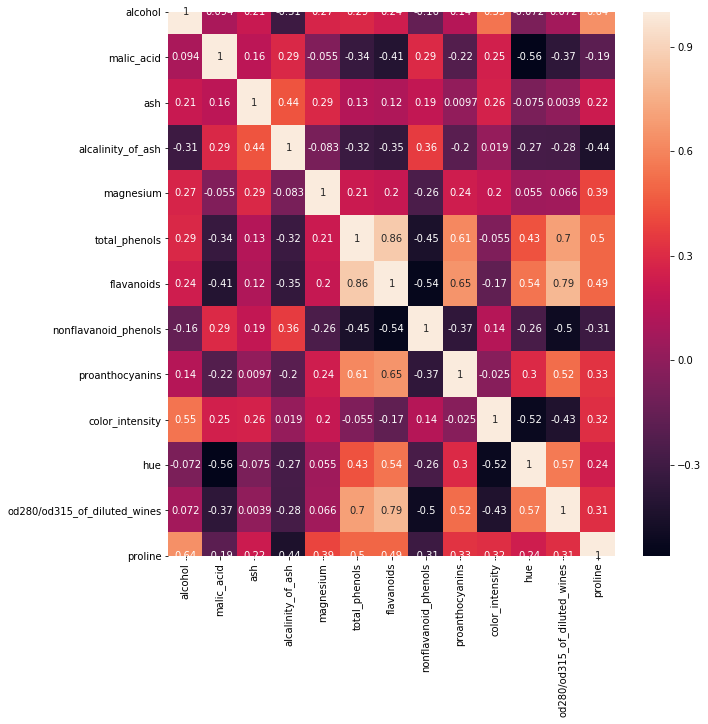

In [0]:
import seaborn as sns

_ = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(X.corr(), annot=True)

In [0]:
X.corr().loc[['alcohol', 'ash', 'hue'], ['alcohol', 'ash', 'hue']]

,alcohol,ash,hue
alcohol,1.000000,0.211545,-0.071747
ash,0.211545,1.000000,-0.074667
hue,-0.071747,-0.074667,1.000000


#### Задание 4

Разбейте выборку на train и test в соотношении 70/30.

In [0]:
from sklearn.model_selection import train_test_split

# ВАШ КОД ЗДЕСЬ:

X_train.head()

NameError: ignored

Выполним нормировку данных

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Подобрать "веса" объекта scaler
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Задание 5

Обучите линейную регрессию и подсчитайте качество на тесте

In [0]:
regressor = LinearRegression()

# ВАШ КОД ЗДЕСЬ
regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)

print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

print('test mse: ', mean_squared_error(y_test, predictions))

Train RMSE:  0.24323462684318337
Test RMSE:  0.26273053934393537
test mse:  0.06902733630395516


Визуализируем получившиеся веса

<BarContainer object of 13 artists>

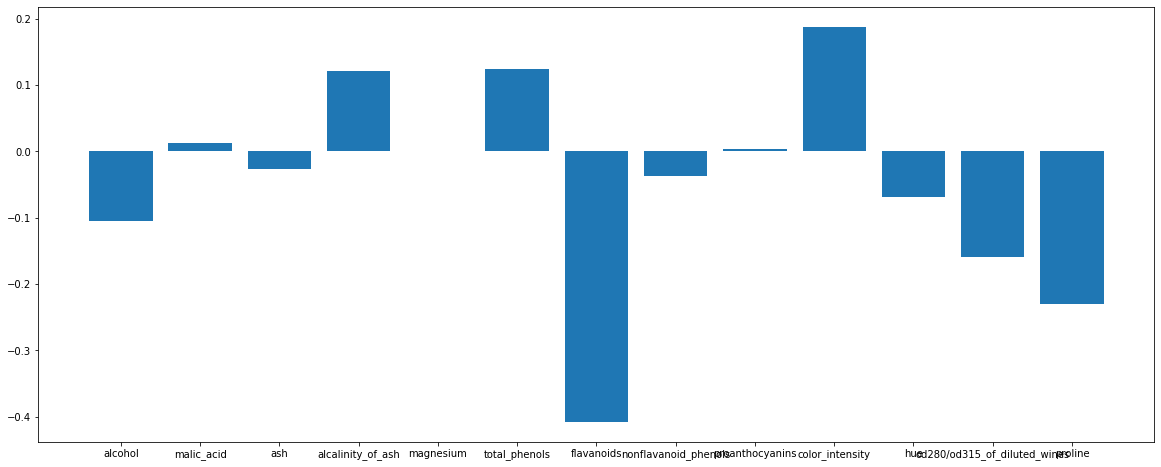

In [0]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, regressor.coef_)

Теперь обратимся к методам с регуляризацией.

Ridge (L2-регуляризация) сильно штрафует за слишком большие веса и не очень за малые. При увеличении коэффициента перед регуляризатором веса меняются плавно

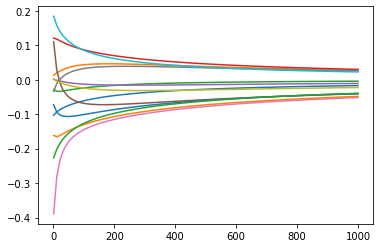

In [0]:
alphas = np.linspace(1, 1000, 100)

weights = np.empty((len(X.columns), 0))
for alpha in alphas:
    ridge_regressor = Ridge(alpha)
    ridge_regressor.fit(X_train, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))
plt.plot(alphas, weights.T)
plt.show()

Lasso одинаково сильно штрафует малые и большие веса, поэтому при достаточно большом коэффициенте регуляризации многие признаки становятся равными нулю, при этом остаются только наиболее инфромативные. Этот факт можно использовать для решения задачи отбора признаков.

['alcalinity_of_ash', 'flavanoids', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['alcalinity_of_ash', 'flavanoids', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['flavanoids', 'od280/od315_of_diluted_wines', 'proline']
['flavanoids', 'od280/od315_of_diluted_wines']
['flavanoids']
['flavanoids']
[]
[]
[]
[]


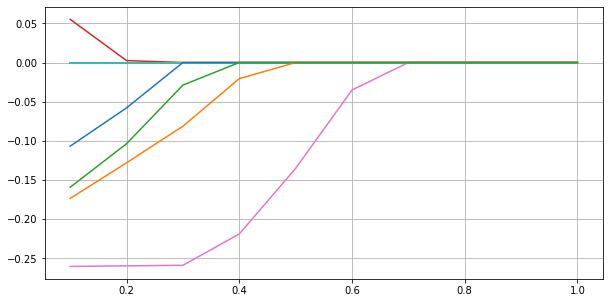

In [0]:
alphas = np.linspace(0.1, 1, 10)

plt.figure(figsize=(10, 5))
weights = np.empty((len(X.columns), 0))
for alpha in alphas:
    lasso_regressor = Lasso(alpha)
    lasso_regressor.fit(X_train, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))
    print([name for (name, coef) in zip(X.columns, lasso_regressor.coef_) if np.abs(coef) > 1e-4])
plt.plot(alphas, weights.T)
plt.grid()
plt.show()

#### Задание 6

Обучите модели Ridge и Lasso и подсчитайте ошибку на тесте. Постарайтесь подобрать лучшие параметры регуляризации

In [0]:
# можно менять этот параметр:
l2_coef = 0.1
ridge = Ridge(l2_coef)
ridge.fit(X_train, y_train)
print('mse ridge: ', mean_squared_error(y_test, ridge.predict(X_test)))

# и этот:
l1_coef = 0.001
lasso = Lasso(l1_coef)
lasso.fit(X_train, y_train)
print('mse lasso: ', mean_squared_error(y_test, lasso.predict(X_test)))

mse ridge:  0.0688803323809465
mse lasso:  0.0684365958707419


#### Линейные методы классификации

Рассмотрим работу алгоритмов линейной классификации для задачи breast cancer

In [0]:
from sklearn.datasets import load_breast_cancer

In [0]:
data = load_breast_cancer()

In [0]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [0]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357]))

In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [0]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


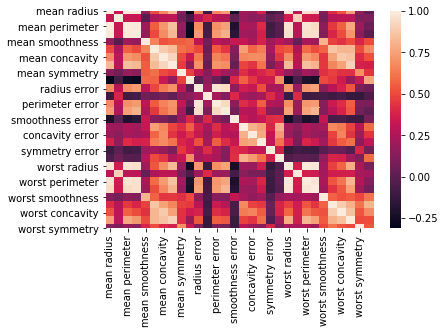

In [0]:
sns.heatmap(X.corr())

Первый метод -- логистическая регрессия. Несмотря на название, данный метод применяется именно в задачах классификации. Регрессия служит указанием на то, что мы пытаемся предсказать вероятность принадлежности классу

#### Задание 7

Разбейте выборку на трейн и тест в соотношении 4:1. Обучите модель и предскажите вероятности классов 0 и 1 (это можно сделать с помощью метода $\textbf{predict_proba}$)

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

# ВАШ КОД ЗДЕСЬ

predictions = <...>

SyntaxError: ignored

In [0]:
predictions.shape

Подсчитаем accuracy и roc-auc наших предсказаний

In [0]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score

In [0]:
accuracy_score(y_test, predictions[:, 1] > 0.5)

In [0]:
fpr, tpr, _ = roc_curve(y_test, predictions[:, 1])
auc = roc_auc_score(y_test, predictions[:, 1])

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [0]:
auc

#### Задание 8

Обучите линейный SVM и подсчитайте точность его предсказаний на тесте. Подсчитайте и ROC-AUC. Что можно сказать про эти результаты?

Замечание: чтобы создать классический линейный SVM нужно в качестве параметра в конструктор передать kernel="linear"

In [0]:
from sklearn.svm import SVC

In [0]:
#### ВАШ КОД ЗДЕСЬ

SVM очень мощный алгоритм и долгое время он использовался почти во всех областях как основной инструмент для построения систем искуственного интеллекта (прямо как нейросети сейчас).

Однако его мощь приносит и немало слабостей. В частности он оказывается довольно чувствительным к шуму в данных и наличию несбалинсированности в классах.

Один из способов побороть вторую проблему -- давать бОльшие веса тем объектам, которых в выборке встречается меньше, тогда при обучении оба класса будут иметь одинаковый вклад в функцию потерь и модель будет обучаться лучше.

#### Задание 8

Разберитесь какой аргумент нужно передать в конструктор, чтобы модель боролась с несбалансированностью классов и обучите ее. Получилось ли улучшить качество?

In [0]:
#### ВАШ КОД ЗДЕСЬ 

#### Задание 9

Побороть шум и улучшить сходимость модели помогает нормировка признаков. Выполните ее и обучите предыдущую модель.

In [0]:
#### ВАШ КОД ЗДЕСЬ

#### Задание 10*

Возьмем датасет содержащий информацию о клиентах и маркетинговой кампании некоторого банка. Задача - предсказать успешность кампании для каждого клиента (воспользуется услугой или нет) 

In [0]:
# Считаем данные
# data = pd.read_csv('bank-additional-full.csv', sep=';')
data = pd.read_csv('https://github.com/h2oai/h2o-2/raw/master/smalldata/bank-additional-full.csv', sep=';')

In [0]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [0]:
X = data.iloc[:, :-1].copy()
y = data.iloc[:, -1].copy()

# Бинаризуем таргет
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(y).ravel()

Классы очень несбалансированы:

In [0]:
y.mean()

0.11265417111780131

Заметим, что среди признаков достаточно много категориальных, в то время как линейные модели работают с числовыми признаками.

Одним из способов получить числовые значения категориальных параметров является One-hot encoding. Его суть состоит в том, что для каждого категориального признака $f$ и каждого его значения $v$ создается новый признак, который равен 1 если у объекта значение $f$ равно $v$ и 0 иначе.

One-hot encoding с помощью pandas можно сделать одной строчкой:

In [0]:
X = pd.get_dummies(X)

# Обратите внимание на признаки
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
age                              41188 non-null int64
duration                         41188 non-null int64
campaign                         41188 non-null int64
pdays                            41188 non-null int64
previous                         41188 non-null int64
emp.var.rate                     41188 non-null float64
cons.price.idx                   41188 non-null float64
cons.conf.idx                    41188 non-null float64
euribor3m                        41188 non-null float64
nr.employed                      41188 non-null float64
job_admin.                       41188 non-null uint8
job_blue-collar                  41188 non-null uint8
job_entrepreneur                 41188 non-null uint8
job_housemaid                    41188 non-null uint8
job_management                   41188 non-null uint8
job_retired                      41188 non-null uint8
job_self-employed

Разобьем выборку на трейн и тест

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Обучим линейный SVM

In [0]:
model_svm = SVC(kernel='linear')
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, y_pred))
print('Test F measure: ', f1_score(y_test, y_pred))

Test accuracy:  0.8942704539936878
Test F measure:  0.4806201550387597


Логистическая регрессия

In [0]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_pred = model_logistic.predict_proba(X_test)[:, 1]
print('Test accuracy: ', accuracy_score(y_test, y_pred))
print('Test F measure: ', f1_score(y_test, y_pred))
print('Test ROC-AUC: ', roc_auc_score(y_test, y_pred))

In [0]:
# Ваши идеи по улучшению моделей